In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from itertools import product

In [2]:
def random_matrix(size:int, non_zero_proba: float):
    A = np.zeros((size,size))
    non_zeros = int(A.size*non_zero_proba)
    for i in range(non_zeros):
        x = np.random.randint(size)
        y = np.random.randint(size)
        while A[x,y] != 0:
            x = np.random.randint(size)
            y = np.random.randint(size)
        A[x,y] = np.random.random()
    return A

In [3]:
def divide(A):
    X, Y = A.shape
    return A[:X//2,:Y//2],A[:X//2,Y//2:],A[X//2:,:Y//2],A[X//2:,Y//2:]

In [4]:
class MatrixTree:
    def __init__(self, matrix:np.ndarray):
        self.matrix = matrix
        self.shape = matrix.shape
        self.zeros = None
        self.A11 = None
        self.A12 = None
        self.A21 = None
        self.A22 = None
        self.u = None
        self.vT = None
    def compute(self):
        if self.matrix is not None:
            return self.matrix
        elif self.zeros is not None:
            return np.zeros(self.zeros)
        elif self.A11 is not None:
            a11, a12, a21, a22 = (i.compute() for i in (self.A11, self.A12, self.A21, self.A22))
            U = np.hstack((a11,a12))
            L = np.hstack((a21,a22))
            return np.vstack((U,L))
        else:
            return self.u @ self.vT
    def paint(self):
        if self.matrix is not None:
            image = np.zeros(self.matrix.shape)
        elif self.zeros is not None:
            image = np.ones(self.zeros)
        elif self.A11 is not None:
            a11, a12, a21, a22 = (i.paint() for i in (self.A11, self.A12, self.A21, self.A22))
            U = np.hstack((a11,a12))
            L = np.hstack((a21,a22))
            image = np.vstack((U,L))
        else:
            shape = (self.u.shape[0], self.vT.shape[1])
            image = np.ones(shape)
            image[:,:self.u.shape[1]] = np.zeros(self.u.shape)
            image[:self.vT.shape[0],:] = np.zeros(self.vT.shape)
        return image
    def draw(self):
        plt.gray()
        plt.imshow(self.paint())
        plt.show()

In [5]:
def get_tolerated(v, tol, a = 0, b = None):
    #print("a: ",a,end="\t")
    #print("b: ",b,end="\t")
    #wyszukiwanie binarne najmniejszego elementu niemniejszego od tolerance
    if b == None:
        b = len(v)-1
    m = (a + b)//2
    if v[b]>tol:
        return v[:b+1]
    #print("m: ",m)
    val = v[m]
    if  a == b:
        if val >= tol:
            return v[:m+1]
        return []
    if val < tol:
        return get_tolerated(v, tol, a, m-1)
    elif m+1<len(v) and v[m+1]<tol:
        return v[:m+1]
    return get_tolerated(v, tol, m, b)
    

In [6]:
def decompose(tree: MatrixTree, u: np.ndarray, d: np.ndarray, vT: np.ndarray) -> None:
    if len(d)==0:
        #print("zero rank matrix")
        tree.zeros=tree.matrix.shape
        tree.matrix = None
        return
    tree.matrix = None
    d = np.diag(d) if len(d)>1 else np.array([d])
    #print("d:\t",d)
    #print("u:\t",u)
    tree.u = u @ d
    tree.vT = vT

In [7]:
def compress(tree: MatrixTree, sigma: float, b: int):
    #print(tree.matrix.shape)
    #print(max_depth)
    if not np.any(abs(tree.matrix) > 1e-4):
        #print(tree.matrix.shape)
        tree.zeros = tree.matrix.shape
        tree.matrix = None
        return
    if tree.matrix.size <= 1:
        return
    u, s, vT = np.linalg.svd(tree.matrix)
    s = get_tolerated(s, sigma)
    new_rank = len(s)
    if new_rank <= b:
        u  =  u[:, :new_rank]
        vT = vT[:new_rank, :]
        decompose(tree, u, s, vT)
        return
    else:
        A11, A12, A21, A22 = divide(tree.matrix)
        tree.matrix = None
        tree.A11 = MatrixTree(A11)
        tree.A12 = MatrixTree(A12)
        tree.A21 = MatrixTree(A21)
        tree.A22 = MatrixTree(A22)
        compress(tree.A11, sigma, b)
        compress(tree.A12, sigma, b)
        compress(tree.A21, sigma, b)
        compress(tree.A22, sigma, b)

In [8]:
A = random_matrix(64,0.2)

In [9]:
t = MatrixTree(A)

In [10]:
compress(t,0.01,4)

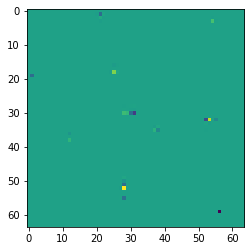

In [11]:
plt.imshow(t.compute()-A)

In [12]:
np.linalg.norm(t.compute()-A)

0.013960493662195903

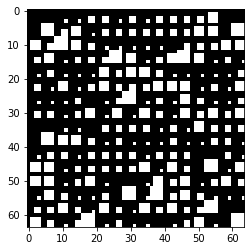

In [13]:
t.draw()

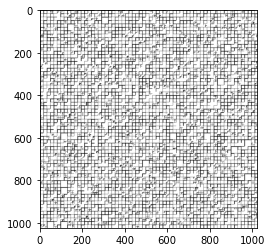

In [14]:
A = random_matrix(1024,0.01)
t = MatrixTree(A)
compress(t,0.01,3)
t.draw()

In [15]:
k = 2048
probs = [0.01,0.02,0.05,0.10,0.20] 
matrices = [random_matrix(k,i) for i in probs]

In [16]:
def test_matrix(matrix, sigma, b):
    t = MatrixTree(matrix)
    fig, axs = plt.subplots(1,2)
    fig.set_size_inches(20, 10)
    u, s, vT = np.linalg.svd(t.matrix)
    start = dt.datetime.now()
    compress(t, sigma, b)
    end = dt.datetime.now()
    plt.gray()
    axs[0].imshow(t.paint())
    axs[0].axis('off')
    axs[1].plot(s)
    axs[1].grid()
    print(f"the differense between matrices is {np.sqrt(np.sum((t.compute()-matrix)**2)):.2f}")
    print(f"compression time in seconds: {(end-start).total_seconds()}")
    plt.show()

test for matrix denseness = 0.01, δ = σ0, b = 1
the differense between matrices is 59.48
compression time in seconds: 0.41917


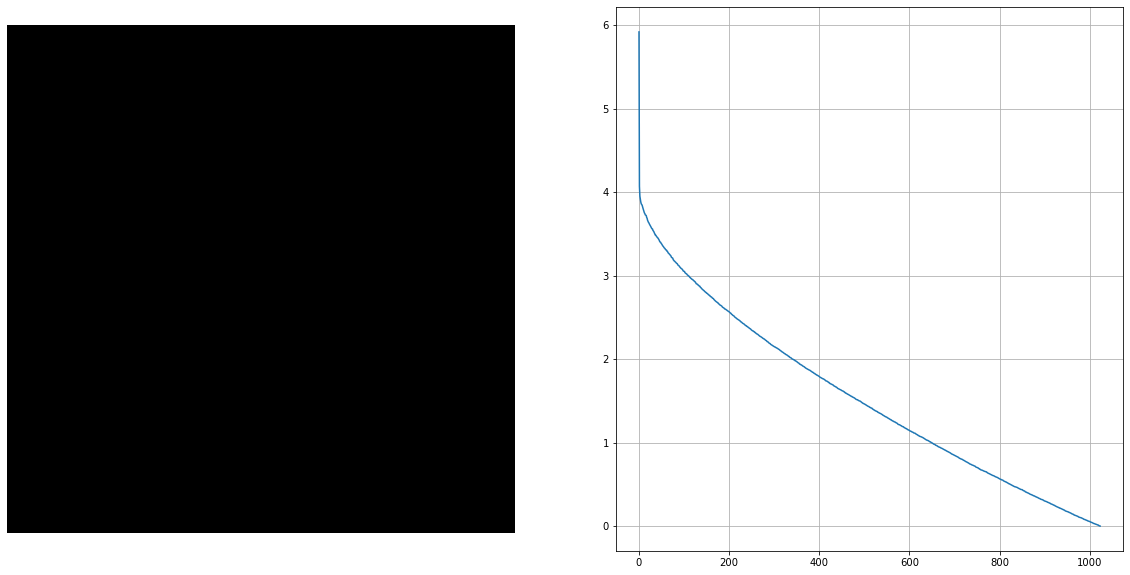

test for matrix denseness = 0.01, δ = σ0, b = 4
the differense between matrices is 58.65
compression time in seconds: 0.428004


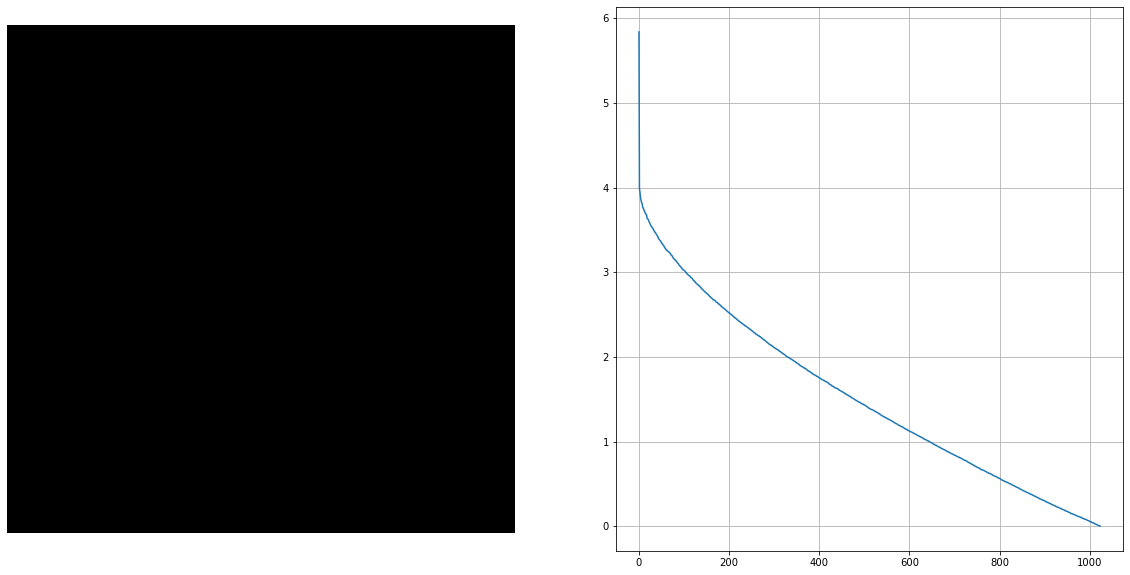

test for matrix denseness = 0.01, δ = σ512, b = 1
the differense between matrices is 57.68
compression time in seconds: 1.150999


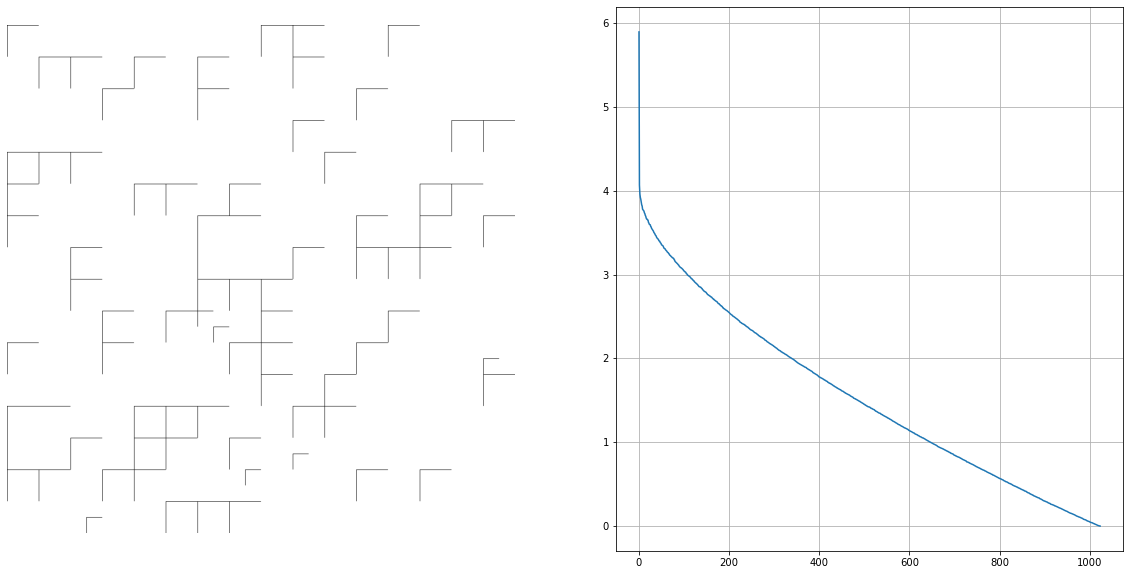

test for matrix denseness = 0.01, δ = σ512, b = 4
the differense between matrices is 55.65
compression time in seconds: 1.088413


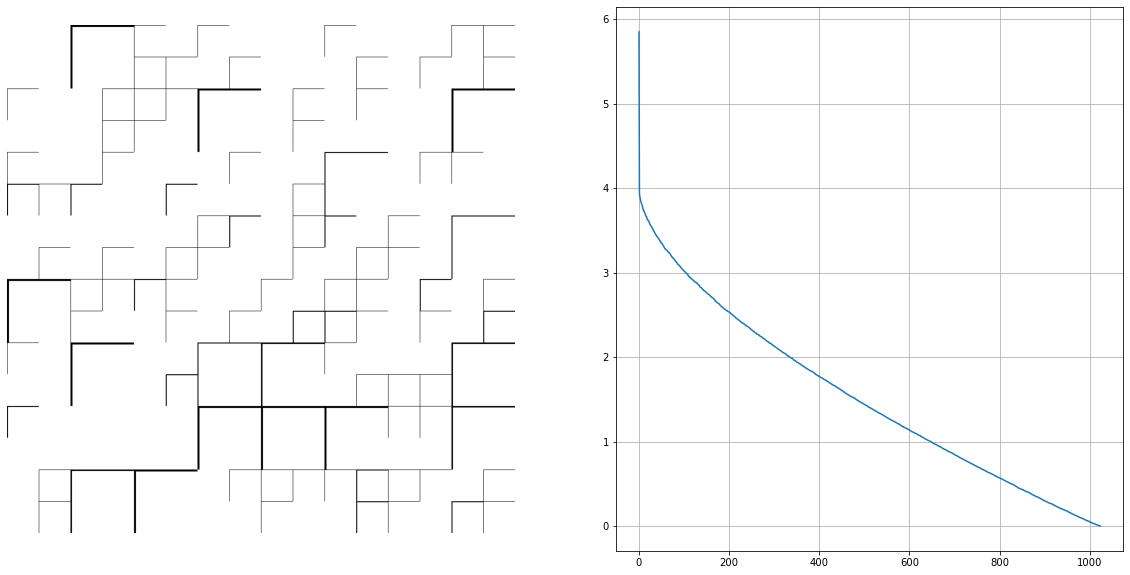

test for matrix denseness = 0.01, δ = σ1023, b = 1
the differense between matrices is 0.00
compression time in seconds: 2.159094


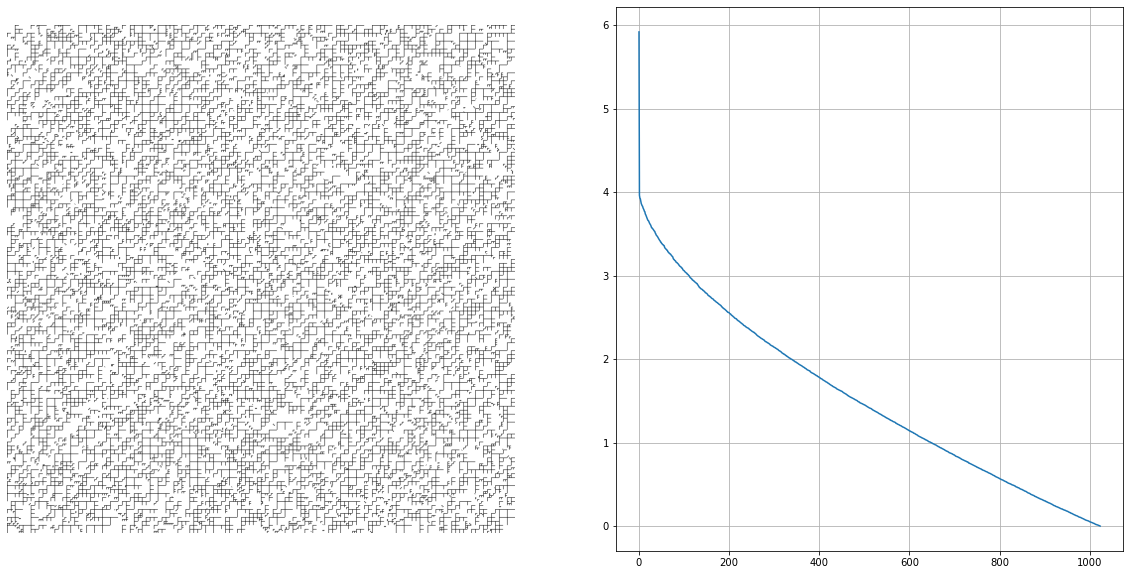

test for matrix denseness = 0.01, δ = σ1023, b = 4
the differense between matrices is 0.00
compression time in seconds: 1.503121


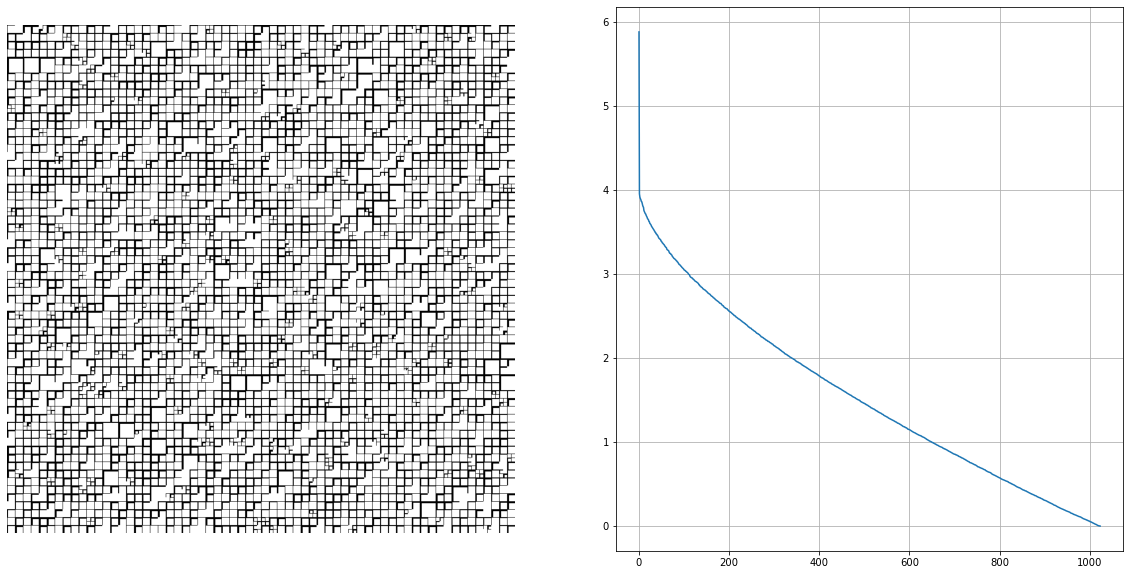

test for matrix denseness = 0.02, δ = σ0, b = 1
the differense between matrices is 83.41
compression time in seconds: 0.518998


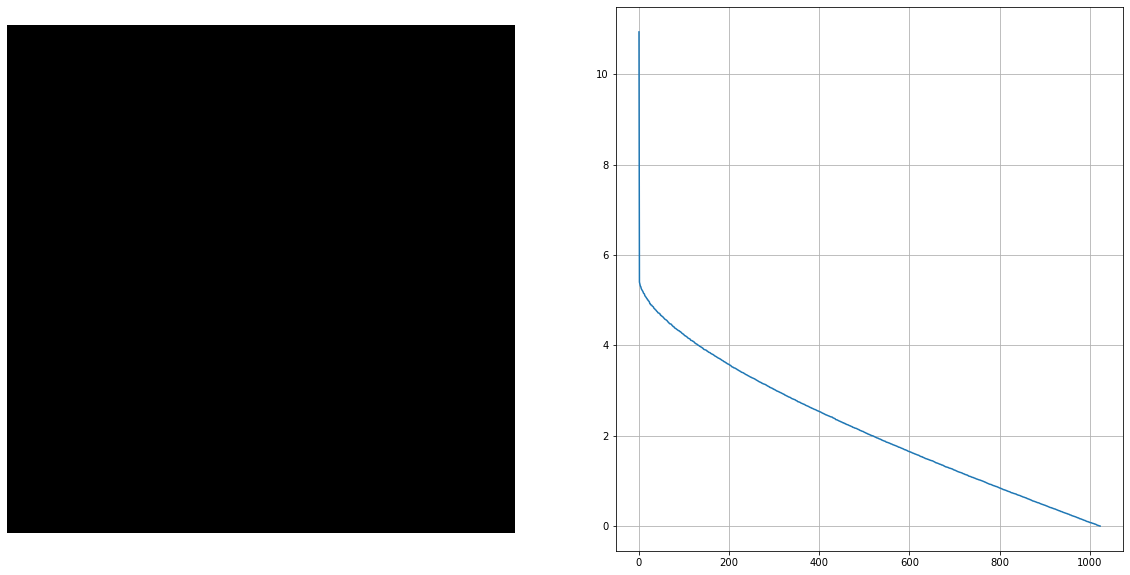

test for matrix denseness = 0.02, δ = σ0, b = 4
the differense between matrices is 82.76
compression time in seconds: 0.624001


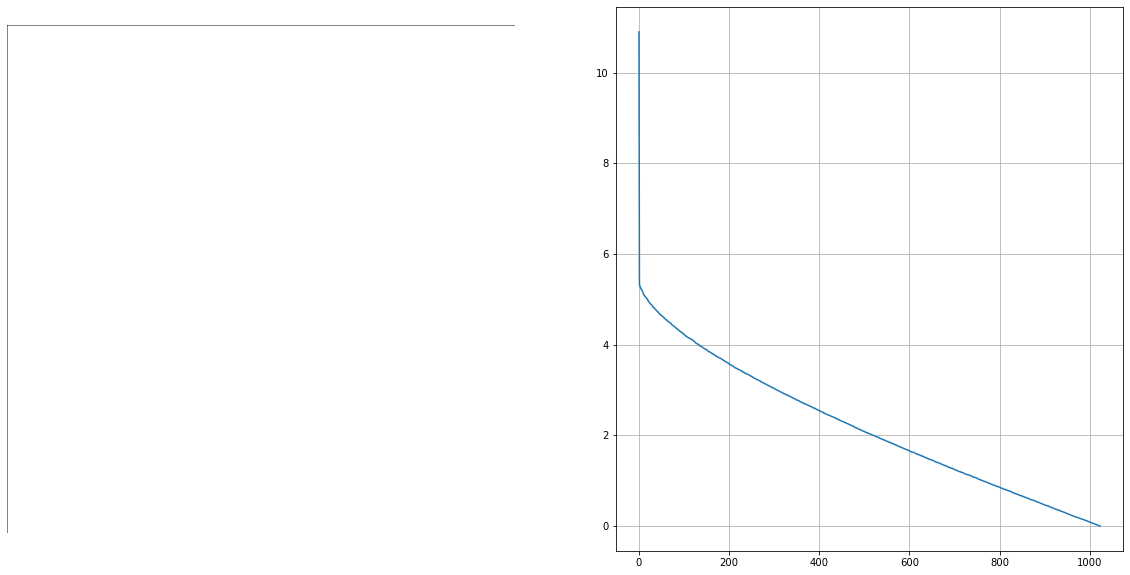

test for matrix denseness = 0.02, δ = σ512, b = 1
the differense between matrices is 82.89
compression time in seconds: 1.587043


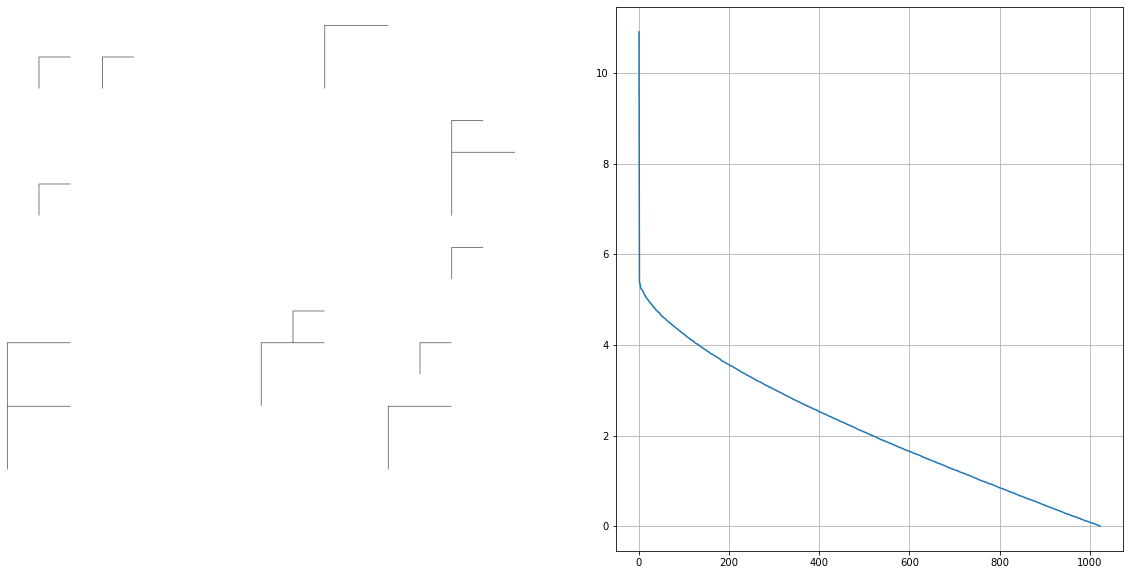

test for matrix denseness = 0.02, δ = σ512, b = 4
the differense between matrices is 79.00
compression time in seconds: 1.328106


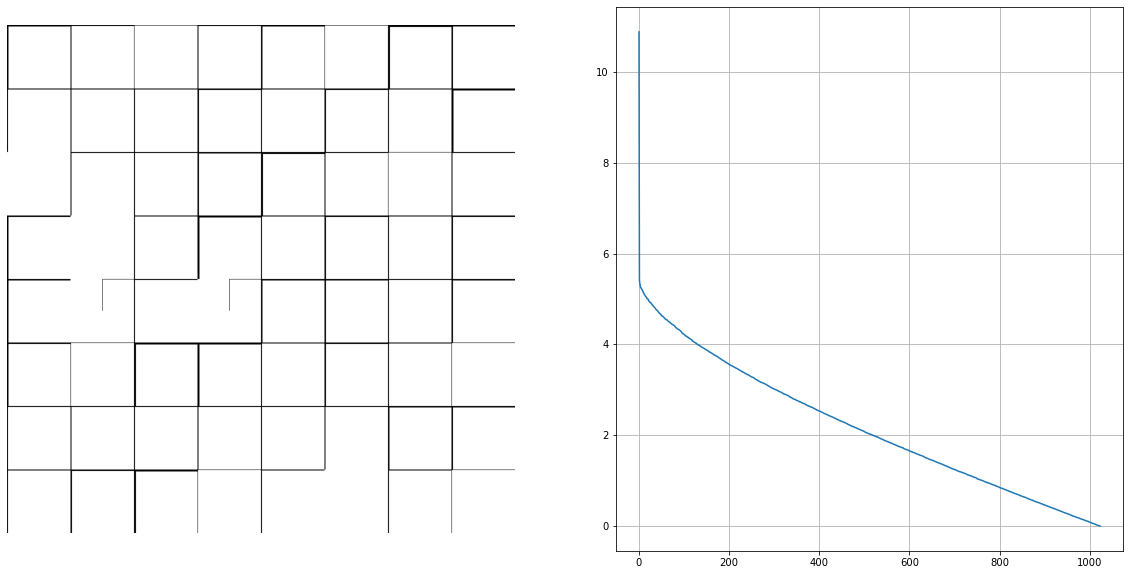

test for matrix denseness = 0.02, δ = σ1023, b = 1
the differense between matrices is 0.00
compression time in seconds: 4.09734


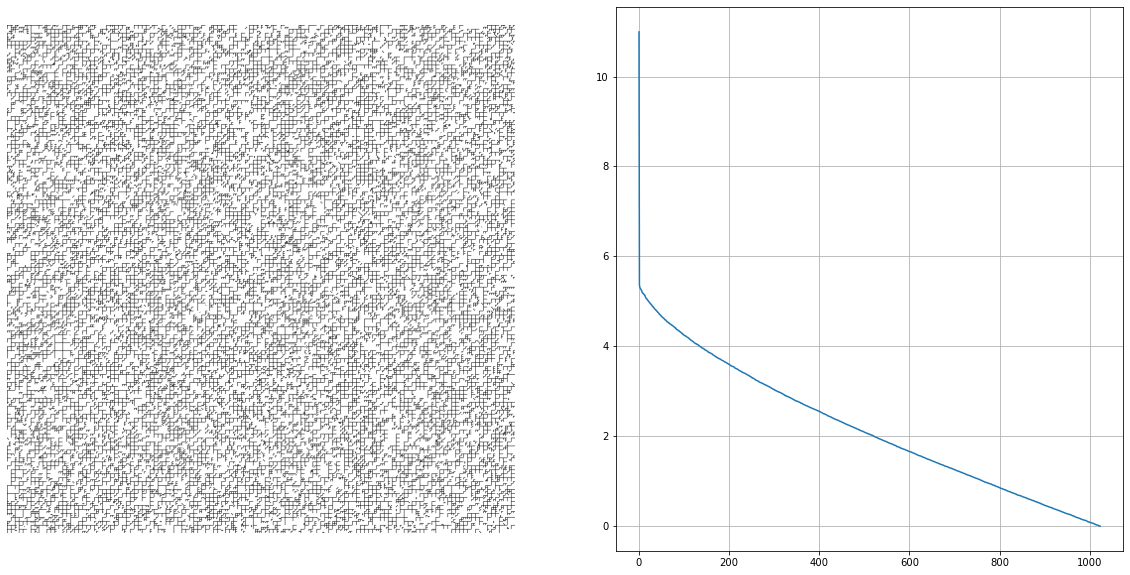

test for matrix denseness = 0.02, δ = σ1023, b = 4
the differense between matrices is 0.01
compression time in seconds: 2.694739


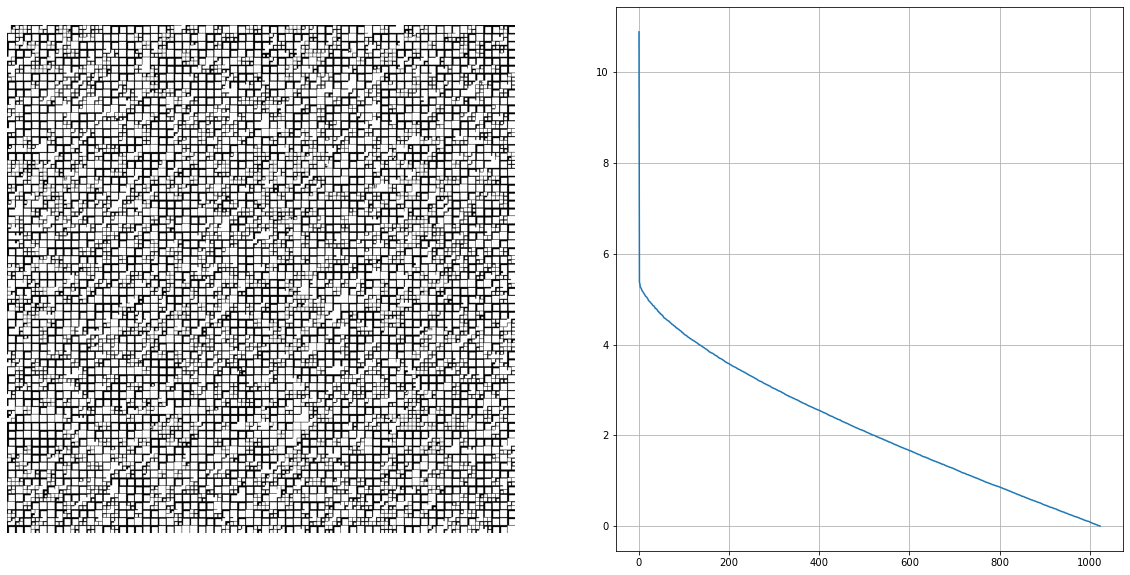

test for matrix denseness = 0.05, δ = σ0, b = 1
the differense between matrices is 129.52
compression time in seconds: 0.536


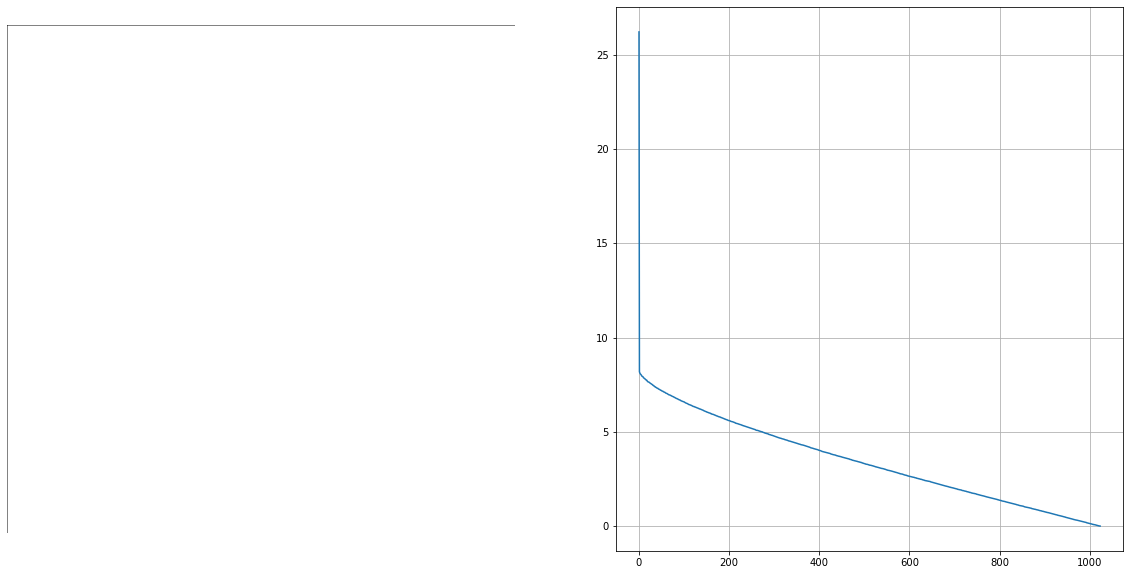

test for matrix denseness = 0.05, δ = σ0, b = 4
the differense between matrices is 129.58
compression time in seconds: 0.503998


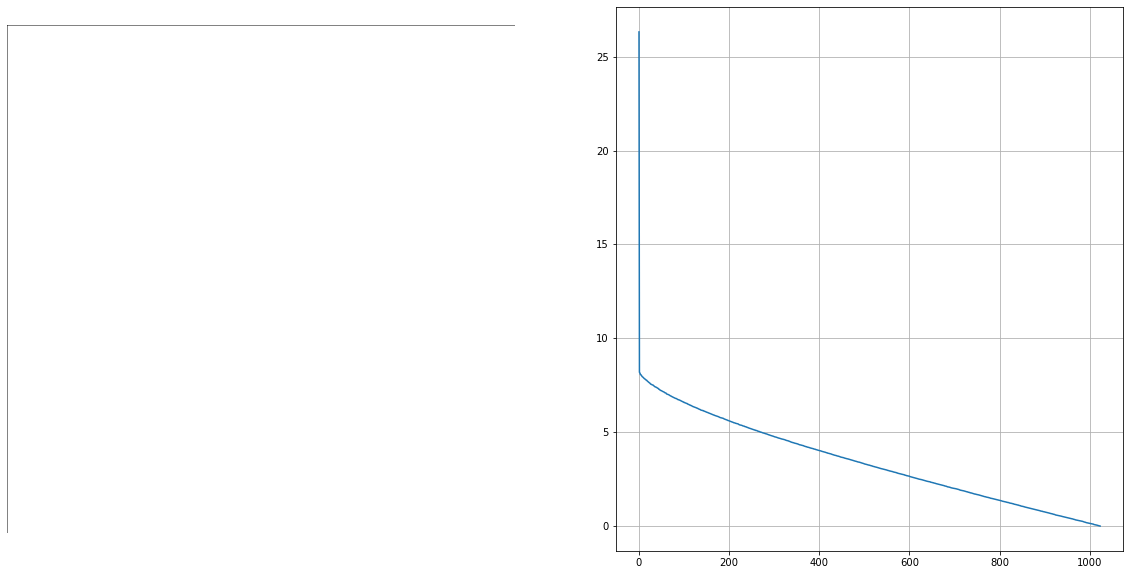

test for matrix denseness = 0.05, δ = σ512, b = 1
the differense between matrices is 128.23
compression time in seconds: 1.300003


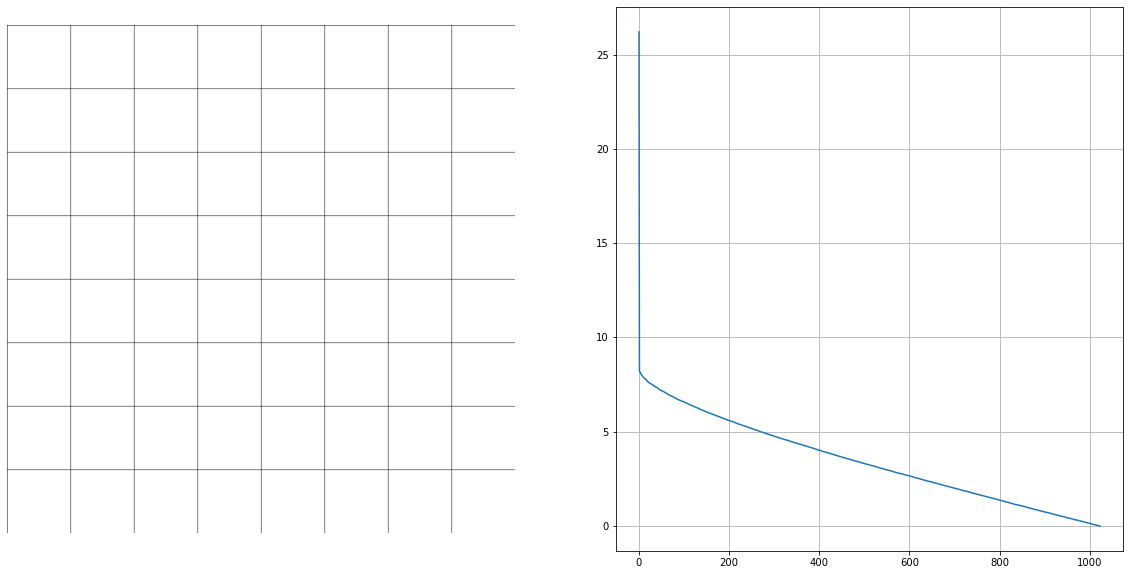

test for matrix denseness = 0.05, δ = σ512, b = 4
the differense between matrices is 128.04
compression time in seconds: 1.376002


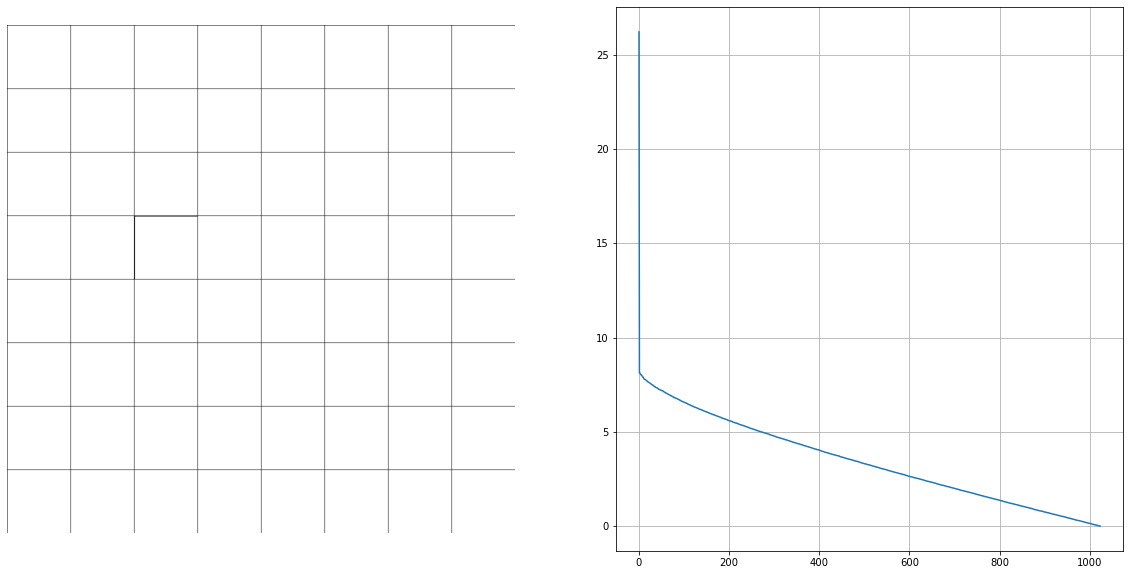

test for matrix denseness = 0.05, δ = σ1023, b = 1


In [ ]:
for prob, sigma_index, b in  product((0.01,0.02,0.05,0.10,0.20), (0,1024,2047), (1,4)):
    matrix = random_matrix(k,prob)
    sigma = np.linalg.svd(matrix,compute_uv=False)[sigma_index]
    print(f"test for matrix denseness = {prob}, \u03B4 = \u03C3{sigma_index}, b = {b}")
    test_matrix(matrix,sigma,b)